# Analysis of the code

Here we generate a noisy signal, in particular a low frequency sinusoidal signal with a high frequency noise. Then we will write the signal in a txt file named "input_vectors.txt", after that the vhd files will be compiled and the entity fir_filter_4_tb will be run. The output of this execution will be saved in another txt file named "output_results.txt" and through python we can compare the input signal, the output signal obtained through the vhd code, and the output signal obtained using the library scipy.signal

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from numpy import savetxt, loadtxt
from scipy.signal import lfilter, firwin #fundamental to simulate a fir_filter in python

In [9]:
data_size = 100
noise = 1 # the higher the noisier

# we now open the file input_vectors.txt so that the vhd code can process it
f = open("input_vectors.txt", "w")

input_sig = []

for i in range(data_size):
    sig = 30*(2+np.sin(i/10)+ noise)
    noise = -noise
    f.write('%d\n' % sig.astype(int)) # we write it as an int
    input_sig.append(sig.astype(int)) # we write it as an int

In [10]:
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

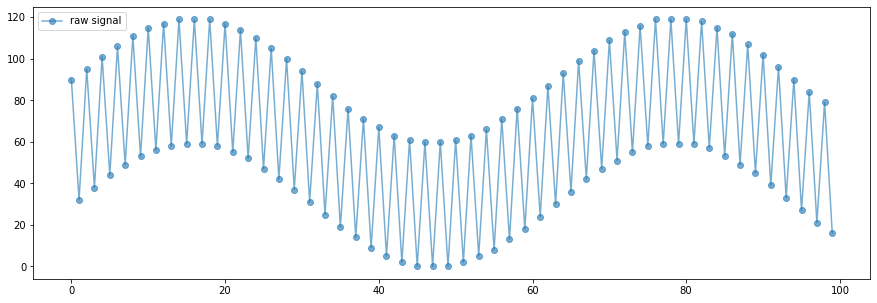

In [11]:
plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

The input signal is the one shown above, it contains mainly two frequencies a low frequency  and a high frequency noise, we should expect the Fir Filter to filter out the high noise

### Fir Filter algorithm

A Filter takes as an input a signal $X[n]$ and outputs a refined one $Y[n]$, for the case of a FIR Filter, the law $X[n]\to Y[n]$ is described as follows: 
		$$ Y[n] = \sum_{i=0}^N C_i x[n-i] $$

where $N$ is the filter order. This order is totally arbitrary, the higher the order is, the better the filter performs. In this project, we choosed to implement a 3 order filter.
        
Then our transformation law is
		$$Y[n]=\sum_{i=0}^3 C_ix[n-i]=C_0x[n]+C_1x[n-1]+C_2x[n-2]+C_3x[n-3]$$

When you multiply two numbers of N-bit and M-bit the output dynamic of the multiplication result is (N+M)-bits.

When you perform addition, the number of bit of the result will be incremented by 1.

This means that, considering the coefficients being 8 bits wide, if the input signal is 8 bits, the output signal should have 18 bits.

The algorithm follow this scheme:
<img src="img/firalg1.svg">

In the algorithm 5 processes are considered:
* **p\_input** (initialization): The new value is stored in X[N] and the old ones are shifted one place to the right
* **p\_mult** (multiplication): All the for values X[i] are multiplied by their coefficient $C_i$
* **p_add_st0** (first additions): The additions $X[N]\times C_0 + X[N-1]\times C_1$ and $X[N-2]\times C_2 + X[N-3]\times C_3$ are performed and stored paying attention in avoiding overflows
* **p_add_st1** (final addition): The values of the last process are added together as always paying attention to overflows
* **p_output** (output): The 18 bits output is resized to 10

Let us find the coefficients for this filter:

In [40]:
numtaps = 4
f = 0.1

# this function gives us the coefficients used in the testbench
c = signal.firwin(numtaps, f)
print("Coefficients for the Fir Filter:", c)

# this function simulates the output of a fir_filter
python_sig = lfilter(c, 1.0, input_sig)

Coefficients for the Fir Filter: [0.04566357 0.45433643 0.45433643 0.04566357]


How do we write the coefficients in bits? And how do we deal with a non integer bits multiplication in VHDL?

Through the line of code use ieee.numeric_std.all we can implement additions and multiplications in our code. The main problem is handling multiplications with number less than 1, since we can only do moltiplications only with integers, for example: $$20\times 0.75 = 15$$ In binary terms it means
		$$ 10100_2 \times 0.11_2 = 1111_2$$
       
To realize this, we must scale the quantity $0.11_2$ by multiplying it by $2^Q$ (resulting in a shift of bits) until we obtain an integer, then after the multiplication we can rescale back (shifting to the other direction).
		$$0.11_2 *\times 2^3 = 0.11_2 <<3 = 110$$
Now we can do the multiplication
		$$10100_2\times 110_2 = 1111000_2$$
Then we rescale back
		$$1111000_2 >> 3 = 1111_2 = 15$$

How do we transform the coefficients then?

In [41]:
rc = c * 2**5
trunc_rc = np.round(rc,0).astype(int)
bin_rc = []
hex_rc = []

for i in range(numtaps):
    bin_rc.append(bin(trunc_rc[i]))
    hex_rc.append(hex(trunc_rc[i]))
    
print(bin_rc)
print(hex_rc)

['0b1', '0b1111', '0b1111', '0b1']
['0x1', '0xf', '0xf', '0x1']


Then we will need to rescale the output

In [42]:
# This compiles and run all the necessary vhd code

# Compiling the two files
! ghdl -a fir_filter.vhd
! ghdl -a fir_filter_tb.vhd

# Running the entity
! ghdl -r fir_filter_4_tb

### The results

In [43]:
# we save the result obtained using the testbench in a array named tb
tb = loadtxt("output_results.txt")
tb = tb * 2**3 # we need to recover the correct scaling due to right shift

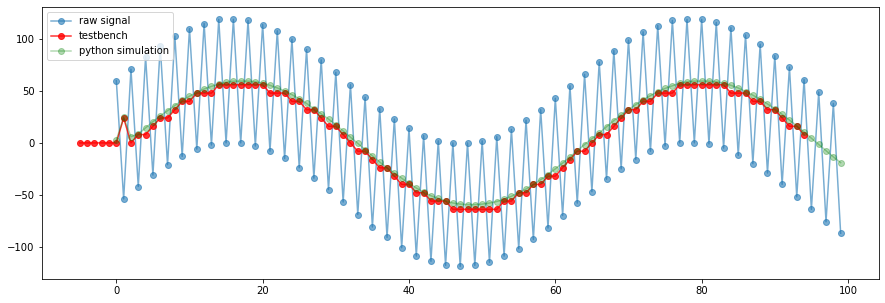

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.plot(t-5, tb, '-o', color='r',alpha=.8,label='testbench')
plt.plot(t, python_sig, '-o', color='g',alpha=.3,label='python simulation')
#plt.title("")
#plt.xlim(0,130) #just for the latex report
plt.legend(loc="upper left")